In [1]:
# Jupyter notebook related
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [132]:
# Built-in modules
import os
import json
import datetime as dt
from typing import Tuple, List

# Basics of Python data handling and visualization
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm.auto import tqdm

# Module for GeoDB
from xcube_geodb.core.geodb import GeoDBClient

# Imports from eo-learn and sentinelhub-py
from sentinelhub import CRS, BBox, SHConfig, DataCollection

from eolearn.core import (FeatureType,
                          EOPatch, 
                          EOTask, 
                          LinearWorkflow, 
                          EOExecutor, 
                          LoadTask,
                          SaveTask)
from eolearn.io import GeoDBVectorImportTask, SentinelHubInputTask
from eolearn.geometry import VectorToRaster

# Imports from eo-learn and sentinelhub-py
from eolearn.core import EOTask, EOPatch, LinearWorkflow, FeatureType, OverwritePermission, \
    LoadTask, SaveTask, EOExecutor, ExtractBandsTask, MergeFeatureTask
from eolearn.io import SentinelHubInputTask, VectorImportTask, ExportToTiff
from eolearn.mask import AddValidDataMaskTask
from eolearn.geometry import VectorToRaster, PointSamplingTask, ErosionTask
from eolearn.features import LinearInterpolation, SimpleFilterTask, NormalizedDifferenceIndexTask
from sentinelhub import UtmZoneSplitter, BBox, CRS, DataCollection

# Visualisation utilities from utils.py
import sys
sys.path.append('ai4eo')
from utils import get_extent, md5_encode_files

In [4]:
scl_dict =  {
    0: [0, 0, 0],  # no data
    1: [1, 0, 0.016],  # saturated / defected
    2: [0.525, 0.525, 0.525],  # dark area pixels
    3: [0.467, 0.298, 0.043],  # cloud shadows
    4: [0.063, 0.827, 0.176],  # vegetation
    5: [1, 1, 0.325],  # bare soils
    6: [0, 0, 1],  # water
    7: [0.506, 0.506, 0.506],  # clouds low probability / unclassified 
    8: [0.753, 0.753, 0.753],  # clouds medium probability
    9: [0.949, 0.949, 0.949],  # clouds high probability
    10: [0.733, 0.773, 0.925],  # cirrus
    11: [0.325, 1, 0.980]  # ice / snow
}

In [195]:
valid_patches = [850, 818, 498, 815, 738, 877, 870, 894, 558, 363] # this is written in the model run logfiles

index = 558

In [196]:
path = "/work/ka1176/shared_data/2021-ai4eo/eopatches/train/"
eopatch = EOPatch.load(os.path.join(path, f'eopatch-{index}'))

In [197]:
from PIL import Image
predicted_image = Image.open(f'/work/ka1176/caroline/gitlab/ai4eo-challenge/ai4eo/submission_TV/eopatch-{index}.tif')
ximg = np.array(predicted_image)

y_true = eopatch.mask_timeless['CULTIVATED'].astype(int).squeeze()

Difference between predicted and actual featuers. 
* Red: predicted cultivated land where there was none (false positive)
* Blue: failed to predict culativaed land (false negative)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


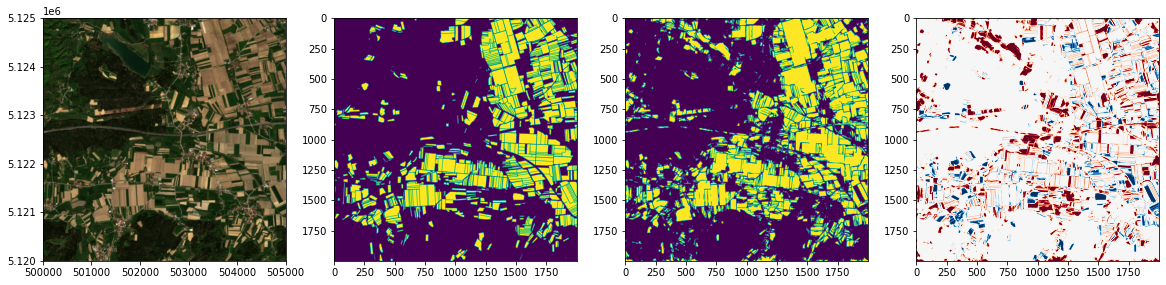

In [198]:
fig, ax = plt.subplots(1, 4, figsize=[20, 5])

tmp = vis_factor * norm_factor * eopatch.data['BANDS'][tidx][..., [3, 2, 1]]
ax[0].imshow(tmp, extent=get_extent(eopatch))
ax[1].imshow(y_true)
ax[2].imshow(ximg)
img=ax[3].imshow(ximg - y_true, cmap='RdBu_r')
#plt.colorbar(img, ax=ax[3])

In [199]:
## Check the INDICES on the validation set

In [200]:
band_names = ['B01','B02','B03','B04','B05','B06','B07','B08','B8A','B09','B11','B12']
# CALCULATING NEW FEATURES
# NDVI: (B08 - B04)/(B08 + B04) vegetation index
# NDWI: (B03 - B08)/(B03 + B08) water index
# NDBI: (B11 - B08)/(B11 + B08) building index
nf = 1e-4
B08 = eopatch.data['BANDS'][tidx][:,:,band_names.index('B08')] * nf
B04 = eopatch.data['BANDS'][tidx][:,:,band_names.index('B04')] * nf
B03 = eopatch.data['BANDS'][tidx][:,:,band_names.index('B03')] * nf
B11 = eopatch.data['BANDS'][tidx][:,:,band_names.index('B11')] * nf

ndvi = (B08 - B04)/(B08 + B04)
ndwi = (B03 - B08)/(B03 + B08)
ndbi = (B11 - B08)/(B11 + B08)

print(np.min(ndvi), np.max(ndvi))
print(np.min(ndwi), np.max(ndwi))
print(np.min(ndbi), np.max(ndbi))

-1.0 0.9714522134877948
-0.9618999237998476 1.0
-0.6746231155778893 1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Buildings')

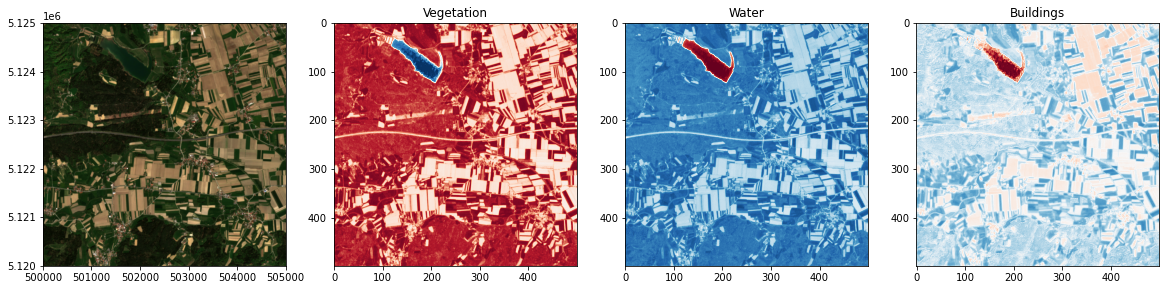

In [201]:
fig, ax = plt.subplots(1, 4, figsize=[20, 5])

tmp = vis_factor * norm_factor * eopatch.data['BANDS'][tidx][..., [3, 2, 1]]
ax[0].imshow(tmp, extent=get_extent(eopatch))
ax[1].imshow(ndvi, vmin=-1, vmax=+1, cmap='RdBu_r')
ax[2].imshow(ndwi, vmin=-1, vmax=+1, cmap='RdBu_r')
img=ax[3].imshow(ndbi, vmin=-1, vmax=+1, cmap='RdBu_r')
ax[1].set_title('Vegetation')
ax[2].set_title('Water')
ax[3].set_title('Buildings')
#plt.colorbar(img, ax=ax[3])

In [51]:
def decrease_resolution(x, sidelength=4):
    cornersRow = np.arange(0, x.shape[0], sidelength)[:, np.newaxis, np.newaxis, np.newaxis]
    cornersCol = np.arange(0, x.shape[1], sidelength)[np.newaxis, :, np.newaxis, np.newaxis]

    subsquareRow = cornersRow + np.arange(sidelength)[:, np.newaxis]
    subsquareCol = cornersCol + np.arange(sidelength)

    subsquares = x[subsquareRow, subsquareCol]
    return np.mean(subsquares, axis=(2,3))

In [152]:
ix_fp = decrease_resolution(ximg - y_true == 1) > 0
ix_fn = decrease_resolution(ximg - y_true == -1) > 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


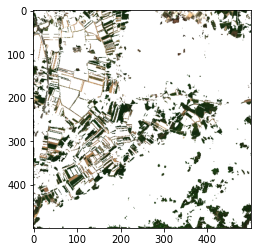

In [153]:
only_fp = np.copy(tmp)
only_fp[ix_fp==0] = 100000
plt.imshow(only_fp)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


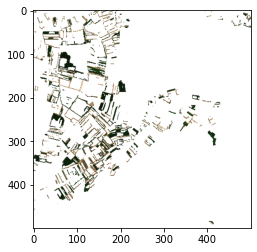

In [154]:
only_fn = np.copy(tmp)
only_fn[ix_fn==0] = 100000
plt.imshow(only_fn)

In [71]:
from sklearn.metrics import matthews_corrcoef

/work/ka1176/caroline/miniconda3/envs/kernel-edc-gpu-mistral/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [78]:

all_mcc = []
all_y_pred = []
all_y_true = []

for index in valid_patches:
    predicted_image = Image.open(f'/work/ka1176/caroline/gitlab/ai4eo-challenge/ai4eo/submission_TV/eopatch-{index}.tif')
    ximg = np.array(predicted_image)
    eopatch = EOPatch.load(os.path.join(path, f'eopatch-{index}'))
    y_true = eopatch.mask_timeless['CULTIVATED'].astype(int).squeeze()
    
    mcc = matthews_corrcoef(y_true.flatten(), ximg.flatten())
    all_mcc.append(mcc)
    
    all_y_pred.append(ximg)
    all_y_true.append(y_true)
    print(index, mcc)

850 0.44402067216922336
818 0.33513296997563935
498 0.3268886225886689
815 0.2759398377100198
738 0.37058519985386884
877 0.42487547029764877
870 0.35163830178062894
894 0.40022519191794587
558 0.5602540241029844
363 0.514697555645344


In [80]:
matthews_corrcoef(np.concatenate(all_y_true).flatten(), np.concatenate(all_y_pred).flatten())

/work/ka1176/caroline/miniconda3/envs/kernel-edc-gpu-mistral/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.41564892689942223

In [81]:
np.mean(np.array(all_mcc))

/work/ka1176/caroline/miniconda3/envs/kernel-edc-gpu-mistral/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.40042578460419725